In [ ]:
import numpy as np
import pandas as pd
import requests
from io import StringIO
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, HashingVectorizer
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
import pandas as pd
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_confusion_matrix
from collections import Counter
from nltk.tokenize import word_tokenize
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
from mlxtend.plotting import plot_confusion_matrix
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import classification_report
import re
import tensorflow as tf
import seaborn as sns
import nltk
import re
from nltk.corpus import stopwords
nltk.corpus.util.LazyCorpusLoader

from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud,STOPWORDS
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize,sent_tokenize

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
train = pd.read_csv("/content/gdrive/My Drive/FakeNewsDataSet/train.csv")
test = pd.read_csv("/content/gdrive/My Drive/FakeNewsDataSet/test.csv")
train.shape

(256442, 6)

In [ ]:
train.head()


,id,tid1,tid2,title1_en,title2_en,label
0,195611,0,1,There are two new old-age insurance benefits f...,"Police disprove ""bird's nest congress each per...",unrelated
1,191474,2,3,"""If you do not come to Shenzhen, sooner or lat...",Shenzhen's GDP outstrips Hong Kong? Shenzhen S...,unrelated
2,25300,2,4,"""If you do not come to Shenzhen, sooner or lat...",The GDP overtopped Hong Kong? Shenzhen clarifi...,unrelated
3,123757,2,8,"""If you do not come to Shenzhen, sooner or lat...",Shenzhen's GDP overtakes Hong Kong? Bureau of ...,unrelated
4,141761,2,11,"""If you do not come to Shenzhen, sooner or lat...",Shenzhen's GDP outpaces Hong Kong? Defending R...,unrelated


In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 256442 entries, 0 to 256441
Data columns (total 6 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   id         256442 non-null  int64 
 1   tid1       256442 non-null  int64 
 2   tid2       256442 non-null  int64 
 3   title1_en  256442 non-null  object
 4   title2_en  256442 non-null  object
 5   label      256442 non-null  object
dtypes: int64(3), object(3)
memory usage: 11.7+ MB


## LSTM2

In [ ]:
import jieba.posseg as pseg
#train=pd.read_csv("/content/gdrive/My Drive/FakeNewsDataSet/train.csv")
cols = ['title1_en', 
        'title2_en', 
        'label']

In [ ]:
train = train.loc[:, cols]
train.head(3)

,title1_en,title2_en,label
0,There are two new old-age insurance benefits f...,"Police disprove ""bird's nest congress each per...",unrelated
1,"""If you do not come to Shenzhen, sooner or lat...",Shenzhen's GDP outstrips Hong Kong? Shenzhen S...,unrelated
2,"""If you do not come to Shenzhen, sooner or lat...",The GDP overtopped Hong Kong? Shenzhen clarifi...,unrelated


In [ ]:
def jieba_tokenizer(text):
    words = pseg.cut(text)
    return ' '.join([
        word for word, flag in words if flag != 'x'])

In [ ]:
train.title2_en.fillna('UNKNOWN', inplace=True)
train.isna().any()

title1_en    False
title2_en    False
label        False
dtype: bool

In [ ]:
def process(data):
    res = data.apply(jieba_tokenizer)
    return res


def check_merge_idx(data, res):
    assert((data.index == res.index).all(), 'Something error when merge data')

def parallelize(data, func):
    from multiprocessing import cpu_count, Pool
    cores = partitions = cpu_count()
    data_split = np.array_split(data, partitions)
    pool = Pool(cores)
    res = pd.concat(pool.map(func, data_split))
    pool.close()
    pool.join()
    check_merge_idx(data, res)
    return res

In [ ]:
np.all(train.index == train.title1_en.index)


True

In [ ]:
train['title1_tokenized'] = parallelize(train.loc[:, 'title1_en'], process)
train['title2_tokenized'] = parallelize(train.loc[:, 'title2_en'], process)
train.to_csv('tokenized_train.csv',index=True)

Building prefix dict from the default dictionary ...
Building prefix dict from the default dictionary ...
Dumping model to file cache /tmp/jieba.cache
Dumping model to file cache /tmp/jieba.cache
Loading model cost 1.336 seconds.
Prefix dict has been built successfully.
Loading model cost 1.381 seconds.
Prefix dict has been built successfully.
Building prefix dict from the default dictionary ...
Loading model from cache /tmp/jieba.cache
Building prefix dict from the default dictionary ...
Loading model from cache /tmp/jieba.cache
Loading model cost 1.028 seconds.
Prefix dict has been built successfully.
Loading model cost 1.045 seconds.
Prefix dict has been built successfully.


In [ ]:
train.loc[:, ["title1_en", "title1_tokenized"]].head(10)


,title1_en,title1_tokenized
0,There are two new old-age insurance benefits f...,There are two new old age insurance benefits f...
1,"""If you do not come to Shenzhen, sooner or lat...",If you do not come to Shenzhen sooner or later...
2,"""If you do not come to Shenzhen, sooner or lat...",If you do not come to Shenzhen sooner or later...
3,"""If you do not come to Shenzhen, sooner or lat...",If you do not come to Shenzhen sooner or later...
4,"""If you do not come to Shenzhen, sooner or lat...",If you do not come to Shenzhen sooner or later...
5,"""How to discriminate oil from gutter oil by me...",How to discriminate oil from gutter oil by mea...
6,"""How to discriminate oil from gutter oil by me...",How to discriminate oil from gutter oil by mea...
7,"""How to discriminate oil from gutter oil by me...",How to discriminate oil from gutter oil by mea...
8,It took 30 years of cooking oil to know that o...,It took 30 years of cooking oil to know that o...
9,It took 30 years of cooking oil to know that o...,It took 30 years of cooking oil to know that o...


In [ ]:
train.loc[:, ["title2_en", "title2_tokenized"]].head(10)


,title2_en,title2_tokenized
0,"Police disprove ""bird's nest congress each per...",Police disprove bird nest congress each person...
1,Shenzhen's GDP outstrips Hong Kong? Shenzhen S...,Shenzhen GDP outstrips Hong Kong Shenzhen Stat...
2,The GDP overtopped Hong Kong? Shenzhen clarifi...,The GDP overtopped Hong Kong Shenzhen clarifie...
3,Shenzhen's GDP overtakes Hong Kong? Bureau of ...,Shenzhen GDP overtakes Hong Kong Bureau of Sta...
4,Shenzhen's GDP outpaces Hong Kong? Defending R...,Shenzhen GDP outpaces Hong Kong Defending Rumo...
5,It's very practical to use a single piece of g...,It very practical to use single piece of garli...
6,Differential gutter oil can be identified with...,Differential gutter oil can be identified with...
7,stir-fried garlic to identify gutter oil,stir fried garlic to identify gutter oil
8,A single piece of garlic can spot gutter oil? ...,single piece of garlic can spot gutter oil Com...
9,"Use a garlic to distinguish oil from oil, very...",Use garlic to distinguish oil from oil very pr...


In [ ]:
train.fillna('UNKNOWN', inplace=True)

In [ ]:
import keras

In [ ]:
MAX_NUM_WORDS = 10000
tokenizer = keras \
    .preprocessing \
    .text \
    .Tokenizer(num_words=MAX_NUM_WORDS)

In [ ]:
corpus_x1 = train.title1_tokenized
corpus_x2 = train.title2_tokenized
corpus = pd.concat([
    corpus_x1, corpus_x2])
corpus.shape

(512884,)

In [ ]:
pd.DataFrame(corpus.iloc[:5],
             columns=['title'])

,title
0,There are two new old age insurance benefits f...
1,If you do not come to Shenzhen sooner or later...
2,If you do not come to Shenzhen sooner or later...
3,If you do not come to Shenzhen sooner or later...
4,If you do not come to Shenzhen sooner or later...


In [ ]:
corpus.isna().any()

False

In [ ]:
tokenizer.fit_on_texts(corpus)
x1_train = tokenizer \
    .texts_to_sequences(corpus_x1)
x2_train = tokenizer \
    .texts_to_sequences(corpus_x2)

In [ ]:
len(x1_train)


256442

In [ ]:
x1_train[:1]

[[66, 16, 57, 28, 23, 251, 557, 786, 11, 23, 29, 6, 87, 446, 20, 8, 431, 178]]

In [ ]:
for seq in x1_train[:1]:
    print([tokenizer.index_word[idx] for idx in seq])

['there', 'are', 'two', 'new', 'old', 'age', 'insurance', 'benefits', 'for', 'old', 'people', 'in', 'rural', 'areas', 'have', 'you', 'got', 'them']


In [ ]:
MAX_SEQUENCE_LENGTH = 20
x1_train = keras \
    .preprocessing \
    .sequence \
    .pad_sequences(x1_train, 
                   maxlen=MAX_SEQUENCE_LENGTH)

x2_train = keras \
    .preprocessing \
    .sequence \
    .pad_sequences(x2_train, 
                   maxlen=MAX_SEQUENCE_LENGTH)

In [ ]:
x1_train[0]

array([  0,   0,  66,  16,  57,  28,  23, 251, 557, 786,  11,  23,  29,
         6,  87, 446,  20,   8, 431, 178], dtype=int32)

In [ ]:
for seq in x1_train + x2_train:
    assert len(seq) == 20
    

In [ ]:
train.label[:5]

0    unrelated
1    unrelated
2    unrelated
3    unrelated
4    unrelated
Name: label, dtype: object

In [ ]:
import numpy as np 

label_to_index = {
    'unrelated': 0, 
    'agreed': 1, 
    'disagreed': 2
}

y_train = train.label.apply(
    lambda x: label_to_index[x])

y_train = np.asarray(y_train) \
            .astype('float32')

y_train[:5]

array([0., 0., 0., 0., 0.], dtype=float32)

In [ ]:
NUM_CLASSES = 3
MAX_NUM_WORDS = 10000
MAX_SEQUENCE_LENGTH = 20
NUM_EMBEDDING_DIM = 256
NUM_LSTM_UNITS = 128

In [ ]:
x1_train[:5]

array([[   0,    0,   66,   16,   57,   28,   23,  251,  557,  786,   11,
          23,   29,    6,   87,  446,   20,    8,  431,  178],
       [ 141,  834,   38,  197,   13,   90,  200,    6,  387,   74,   78,
          33,  748,  582, 5277, 2755,   13, 5104,  524,  632],
       [ 141,  834,   38,  197,   13,   90,  200,    6,  387,   74,   78,
          33,  748,  582, 5277, 2755,   13, 5104,  524,  632],
       [ 141,  834,   38,  197,   13,   90,  200,    6,  387,   74,   78,
          33,  748,  582, 5277, 2755,   13, 5104,  524,  632],
       [ 141,  834,   38,  197,   13,   90,  200,    6,  387,   74,   78,
          33,  748,  582, 5277, 2755,   13, 5104,  524,  632]],
      dtype=int32)

In [ ]:
train.label[:5]

0    unrelated
1    unrelated
2    unrelated
3    unrelated
4    unrelated
Name: label, dtype: object

In [ ]:
y_train = keras \
    .utils \
    .to_categorical(y_train)

y_train[:5]

array([[1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.]], dtype=float32)

In [ ]:
from sklearn.model_selection \
    import train_test_split

VALIDATION_RATIO = 0.1

RANDOM_STATE = 9527

x1_train, x1_val, \
x2_train, x2_val, \
y_train, y_val = \
    train_test_split(
        x1_train, x2_train, y_train, 
        test_size=VALIDATION_RATIO, 
        random_state=RANDOM_STATE
)

In [ ]:
print("Training Set")
print("-" * 10)
print(f"x1_train: {x1_train.shape}")
print(f"x2_train: {x2_train.shape}")
print(f"y_train : {y_train.shape}")

print("-" * 10)
print(f"x1_val:   {x1_val.shape}")
print(f"x2_val:   {x2_val.shape}")
print(f"y_val :   {y_val.shape}")
print("-" * 10)
print("Test Set")

Training Set
----------
x1_train: (230797, 20)
x2_train: (230797, 20)
y_train : (230797, 3)
----------
x1_val:   (25645, 20)
x2_val:   (25645, 20)
y_val :   (25645, 3)
----------
Test Set


In [ ]:
from keras import Input
from keras.layers import Embedding,LSTM, concatenate, Dense
from keras.models import Model

top_input = Input(
    shape=(MAX_SEQUENCE_LENGTH, ), 
    dtype='int32')
bm_input = Input(
    shape=(MAX_SEQUENCE_LENGTH, ), 
    dtype='int32')

embedding_layer = Embedding(
    MAX_NUM_WORDS, NUM_EMBEDDING_DIM)
top_embedded = embedding_layer(
    top_input)
bm_embedded = embedding_layer(
    bm_input)

shared_lstm = LSTM(NUM_LSTM_UNITS)
top_output = shared_lstm(top_embedded)
bm_output = shared_lstm(bm_embedded)

merged = concatenate(
    [top_output, bm_output], 
    axis=-1)


dense =  Dense(
    units=NUM_CLASSES, 
    activation='softmax')
predictions = dense(merged)

model = Model(
    inputs=[top_input, bm_input], 
    outputs=predictions)

model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 20)]         0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 20)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 20, 256)      2560000     input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     (None, 128)          197120      embedding[0][0]       

In [ ]:
from keras.optimizers import Adam

In [ ]:
lr = 1e-3
opt = Adam(lr=lr, decay=lr/50)
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy'])

In [ ]:
x1_train[:9527].shape

(9527, 20)

In [ ]:
BATCH_SIZE = 512

NUM_EPOCHS = 25

history = model.fit(
    x=[x1_train, x2_train], 
    y=y_train,
    batch_size=BATCH_SIZE,
    epochs=NUM_EPOCHS,
    validation_data=(
        [x1_val, x2_val], 
        y_val
    ),
    shuffle=True
)

Epoch 1/25
451/451 [==============================] - 19s 41ms/step - loss: 0.5227 - accuracy: 0.7583 - val_loss: 0.4519 - val_accuracy: 0.7915
Epoch 2/25
451/451 [==============================] - 18s 40ms/step - loss: 0.4054 - accuracy: 0.8175 - val_loss: 0.4311 - val_accuracy: 0.8044
Epoch 3/25
451/451 [==============================] - 18s 40ms/step - loss: 0.3608 - accuracy: 0.8399 - val_loss: 0.4259 - val_accuracy: 0.8140
Epoch 4/25
451/451 [==============================] - 18s 39ms/step - loss: 0.3257 - accuracy: 0.8575 - val_loss: 0.4236 - val_accuracy: 0.8179
Epoch 5/25
451/451 [==============================] - 18s 40ms/step - loss: 0.2953 - accuracy: 0.8709 - val_loss: 0.4309 - val_accuracy: 0.8208
Epoch 6/25
451/451 [==============================] - 18s 39ms/step - loss: 0.2670 - accuracy: 0.8847 - val_loss: 0.4485 - val_accuracy: 0.8239
Epoch 7/25
451/451 [==============================] - 18s 40ms/step - loss: 0.2419 - accuracy: 0.8967 - val_loss: 0.4625 - val_accuracy:

In [ ]:
loss, accuracy = model.evaluate([x1_val,x2_val], y_val, verbose=1)
print("Test: accuracy = %f  ;  loss = %f" % (accuracy, loss))
model.save("model_optimizer_sgd.h5")

802/802 [==============================] - 3s 3ms/step - loss: 1.0112 - accuracy: 0.8234
Test: accuracy = 0.823357  ;  loss = 1.011171


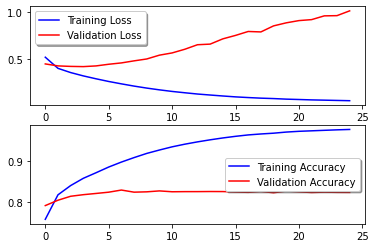

In [ ]:
fig, axs = plt.subplots(2,1)
axs[0].plot(history.history['loss'], color = 'b', label = "Training Loss")
axs[0].plot(history.history['val_loss'], color = 'r', label = "Validation Loss", axes = axs[0])
legend = axs[0].legend(loc='best', shadow = True)

axs[1].plot(history.history['accuracy'], color = 'b', label = "Training Accuracy")
axs[1].plot(history.history['val_accuracy'], color = 'r', label = "Validation Accuracy")
legend = axs[1].legend(loc='best', shadow = True)

In [ ]:
# Function to plot confusion matrix    
import itertools
labels=['unrelated','agreed','disagreed']
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',class_names=labels,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
y_pred=model.predict([x1_val,x2_val])

In [ ]:
y_pred

array([[2.5132859e-02, 9.7486705e-01, 1.3917689e-07],
       [9.9996805e-01, 2.1240075e-10, 3.1919652e-05],
       [4.8793760e-01, 2.3686828e-06, 5.1205999e-01],
       ...,
       [9.9999595e-01, 5.5906512e-15, 4.0340742e-06],
       [1.0000000e+00, 3.3443068e-24, 2.4651894e-09],
       [2.3712891e-01, 7.6270783e-01, 1.6322199e-04]], dtype=float32)

In [ ]:
Y_pred_classes = np.argmax(y_pred,axis = 1) 

In [ ]:
Y_true = np.argmax(y_val,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)


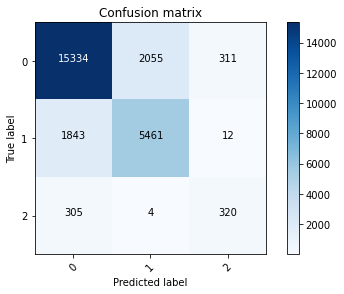

In [ ]:
plot_confusion_matrix(confusion_mtx, classes = range(3),class_names=['unrelated','agreed','disagreed']) 
##  unrelated: 0 
## agreed: 1 
## disagreed: 2

In [ ]:
import pandas as pd
import os

print("Use raw test csv")
test = pd.read_csv("/content/gdrive/My Drive/FakeNewsDataSet/test.csv", index_col=0)
test.fillna('UNKNOWN', inplace=True)
test['title1_tokenized'] = parallelize(test.loc[:, 'title1_en'], process)
test['title2_tokenized'] = parallelize(test.loc[:, 'title2_en'], process)
test.fillna('UNKNOWN', inplace=True)
test.head(3)

Use raw test csv


Building prefix dict from the default dictionary ...
Loading model from cache /tmp/jieba.cache
Building prefix dict from the default dictionary ...
Loading model from cache /tmp/jieba.cache
Loading model cost 1.329 seconds.
Prefix dict has been built successfully.
Loading model cost 1.359 seconds.
Prefix dict has been built successfully.
Building prefix dict from the default dictionary ...
Loading model from cache /tmp/jieba.cache
Building prefix dict from the default dictionary ...
Loading model from cache /tmp/jieba.cache
Loading model cost 1.060 seconds.
Prefix dict has been built successfully.
Loading model cost 1.078 seconds.
Prefix dict has been built successfully.


,tid1,tid2,title1_en,title2_en,title1_tokenized,title2_tokenized
id,,,,,,
256442,100672,100673,"The great coat brother Zhu Zhu Wen, in the man...","Lin xinsheng after the birth of ""hard milking,...",The great coat brother Zhu Zhu Wen in the mand...,Lin xinsheng after the birth of hard milking H...
256443,162269,162270,NASA reveals facts about UFO wreckage found on...,"The UFO found in Yuancun, Jiaocheng County, Sh...",NASA reveals facts about UFO wreckage found on...,The UFO found in Yuancun Jiaocheng County Shan...
256444,157826,157854,The hollow tomatoes are loaded with hormones.,"Li chenfan bingbing home photos, netizen: this...",The hollow tomatoes are loaded with hormones .,Li chenfan bingbing home photos netizen this i...


In [ ]:
x1_test = tokenizer \
    .texts_to_sequences(
        test.title1_tokenized)
x2_test = tokenizer \
    .texts_to_sequences(
        test.title2_tokenized)


x1_test = keras \
    .preprocessing \
    .sequence \
    .pad_sequences(
        x1_test, 
        maxlen=MAX_SEQUENCE_LENGTH)
x2_test = keras \
    .preprocessing \
    .sequence \
    .pad_sequences(
        x2_test, 
        maxlen=MAX_SEQUENCE_LENGTH)    


predictions = model.predict(
    [x1_test, x2_test])

In [ ]:
predictions[:5]

array([[9.9510843e-01, 4.8915548e-03, 7.9956253e-10],
       [9.4480532e-01, 5.4895937e-02, 2.9874462e-04],
       [9.9997568e-01, 1.1213771e-08, 2.4293520e-05],
       [9.4926155e-01, 5.0738495e-02, 1.6313189e-08],
       [9.9999523e-01, 2.0870874e-07, 4.4978647e-06]], dtype=float32)

In [ ]:
index_to_label = {v: k for k, v in label_to_index.items()}

test['Category'] = [index_to_label[idx] for idx in np.argmax(predictions, axis=1)]

submission = test \
    .loc[:, ['Category']] \
    .reset_index()

submission.columns = ['Id', 'Category']
submission.to_csv('submission.csv', index=False)
submission.head()
from google.colab import files
files.download('submission.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>